<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

<h1>Principal Component Analysis (PCA) and Autoencoders </h1> 

<h2>Table of Contents</h2>
<p>In this lab, we will compare Principal Component Analysis (PCA), we will show how it can reduce the dimensions of the data..  </p>

<ul>
    <li><a href="#prep">Preparation</a></li>
    <li><a href="#PCA"> PCA 2D </a></li>
    <li><a href="#A2D">Autoencoders 2D </a></li>
    <li><a href="#PCA3D">PCA 3D</a></li>
    <li><a href="#A3D">Autoencoders 3D </a></li>

</ul>

<p>Estimated Time Needed: <strong>30 min</strong></p>

<hr>

<h2 id="prep">Preparation</h2>

We'll need the following labs and functions: 

In [65]:
# install matplotlib==3.4 in order to apply 3DPlot function
!pip install -U matplotlib==3.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.1/37.1 MB 557.4 kB/s eta 0:00:0000:0100:02
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.4.0-cp310-cp310-macosx_11_0_arm64.whl size=6755059 sha256=b69de59b8e51bfbac0223a1eca2ed00972a2ad29bae041f219b8026c696a158c
  Stored in directory: /Users/danielalvarez/Library/Caches/pip/wheels/27/ea/35/0964d59ed4c7270bbeabc79c0984b58d72f9e4463746bf7062
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.0
    Uninstalling matplotlib-3.5.0:
      Successfully uninstalled matplotlib-3.5.0

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [66]:
# These are the libraries we are going to use in the lab.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import proj3d
import seaborn as sns
import torch
import torch.nn as nn
from matplotlib.patches import FancyArrowPatch

Simple autoencoder module or class 

In [2]:
class AutoEncoder(nn.Module): 
  
    def __init__(self, input_dim=2, encoding_dim=32):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Linear(input_dim,encoding_dim)
        self.decoder = nn.Linear(encoding_dim,input_dim)
    
  
    def forward(self, x):
 
        x=self.encoder(x)
        x=self.decoder(x)
      
        return x

function to train an autoencoder:

In [3]:
def train_model(model,X,optimizer,n_epochs=4):   
    #global variable 
    cost_list_training =[]
    cost_list_validation =[]
    for epoch in range(n_epochs):
        cost_training=0
        for x in X:
           
            model.train()
            optimizer.zero_grad()
            xhat = model(x)
            loss = criterion(xhat, x)
            loss.backward()
            optimizer.step()
            cost_training+=loss.data
        
        cost_list_training.append(cost_training)
     
    return cost_list_training

This function will plot the data in 2D-data.

In [4]:
def plot_data(X,Xhat,vec=False,label_X="data",label_Xhat="transformed data",lable_vec="parameter vector"):

    if type(X) is torch.Tensor:
        plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(),label=label_X) 
    if type(Xhat) is torch.Tensor:   
        plt.scatter(Xhat[:, 0].numpy(), Xhat[:, 1].numpy(),label=label_Xhat)
    if type(vec) is torch.Tensor:
        
        plt.xlabel("q_{1}")
        plt.ylabel("q_{2}")
        plt.quiver([0],[0],vec[:,0],vec[:,1],label=lable_vec)
    plt.legend()
    plt.show()

This function will generate 3D data from a plane and add noise.

In [5]:
def GenerateData(ProjectionMatrix=[[1,-1,0],[2,1,0],[0,0,0]],Noise_std=0.1,Nsamples=1000):
    
    import numpy as np
    np.random.seed(0)

    Max=1
    Min=-1
    #Create a projection matrix
    ProjectionMatrix=np.array([[1,-1,0],[2,1,0],[0,0,0]])
    #Acreate some noise and add to data  
    Noise=Noise_std*np.random.normal(loc=0.0, scale=1, size=(Nsamples,3))
    #Create some uniform data and  projection onto plane 
    TureData=np.dot(ProjectionMatrix,np.random.uniform(low=Min, high=Max, size=(Nsamples,3)).T ).T
    TureData=TureData-TureData.mean( axis=0)
    #add noise 
    CorruptedData =TureData+Noise
    CorruptedData =CorruptedData -CorruptedData .mean( axis=0) 
    return TureData,CorruptedData

This function will plot the 3D data.

In [67]:
def PlotData3D(Data,Data1,Name1="Data 1",Name2="Data 2",BasisVectors=None):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(Data[:,0], Data[:,1], Data[:,2], 'x', markersize=10, color='b', alpha=1,label=Name1)
    ax.plot(Data1[:,0], Data1[:,1], Data1[:,2], 'o', markersize=10, color='r', alpha=0.5,label=Name2)
    
    if type(BasisVectors)==torch.Tensor:
        for q in torch.transpose(BasisVectors,0,1):
            print(q)
            a = Arrow3D([0,q[0].numpy()], [0, q[1].numpy()], [0, q[2].numpy()], mutation_scale=20, lw=3, arrowstyle="-|>", color="k")
            ax.add_artist(a)
  
    ax.set_zlim([-2,2])
    ax.set_xlim([-2,2])
    ax.set_ylim([-2,2])
    ax.legend(shadow=True)

This function will create the arrows in 3D to represent vectors 

In [74]:
# class Arrow3D(FancyArrowPatch):
#     #code by CT Zhu
#     #https://stackoverflow.com/users/2487184/ct-zhu
#     def __init__(self, xs, ys, zs, *args, **kwargs):
#         FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
#         self._verts3d = xs, ys, zs

#     def draw(self, renderer):
#         xs3d, ys3d, zs3d = self._verts3d
#         xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
#         self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
#         FancyArrowPatch.draw(self, renderer)

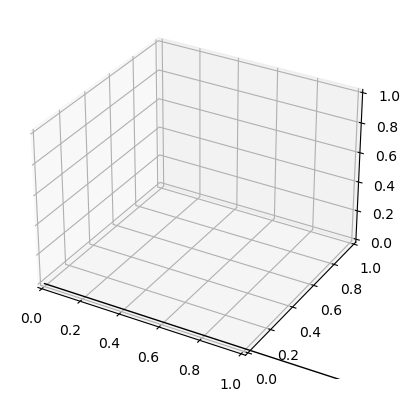

In [72]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
arrow_prop_dict = dict(mutation_scale=20, arrowstyle='-|>', color='k', shrinkA=0, shrinkB=0)
a = Arrow3D([0, 10], [0, 0], [0, 0], **arrow_prop_dict)
ax.add_artist(a)

plt.show()

<h2 id="#PCA "> PCA 2D</h2>
In this section, we create a dataset object that uses Principal component analysis (PCA). We find the projection of the data on the eigenvectors of the covariance matrix $\mathbf{Q}$, as shown below. We zero center the data.

We generate 2D  data that is correlated.

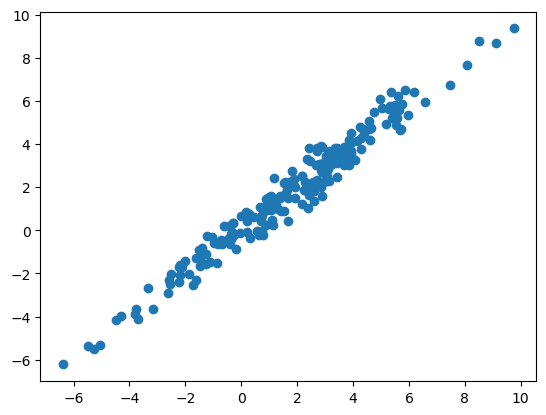

In [8]:
samples=200
u=torch.tensor([[1.0,1.0],[0.10,-0.10]])/(2)**(0.5)
X=torch.mm(4*torch.randn(samples,2),u)+2
plt.scatter(X[:, 0].numpy(), X[:, 1].numpy())
plt.show()


From now on we will deal with zero centered data

$\mathbf x=\mathbf x-\boldsymbol\mu$

In [9]:
X_old=X
X=X-X.mean(dim=0)


We plot the data before we subtract and after we subtract the mean.


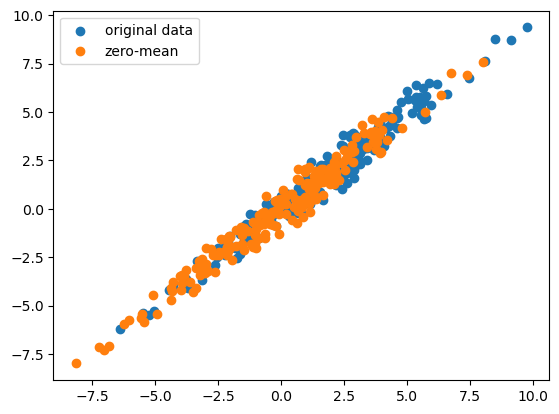

In [10]:
plot_data(X_old,X,label_X="original data",label_Xhat="zero-mean")

$\frac{1}{N}   \mathbf{X}^T \mathbf{X} = \mathbf{Q} \mathbf{\Lambda} \mathbf{Q}^T$



We calculate the empirical covariance matrix.

$\frac{1}{N}   \mathbf{X}^T \mathbf{X}$

In [11]:
Cov=torch.mm(torch.t(X),X)/X.shape[0]
Cov

tensor([[8.1593, 7.9700],
        [7.9700, 8.0757]])

We obtain the eigenvectors
$\frac{1}{N}   \mathbf{X}^T \mathbf{X} = \mathbf{Q} \mathbf{\Lambda} \mathbf{Q}^T$

In [12]:
eigenvalues,eigenvectors=torch.linalg.eig(Cov)
eigenvectors

tensor([[ 0.7090+0.j, -0.7052+0.j],
        [ 0.7052+0.j,  0.7090+0.j]])

we have the eigenvalues:

In [13]:
eigenvalues

tensor([16.0876+0.j,  0.1473+0.j])

we can plot the eigenvectors

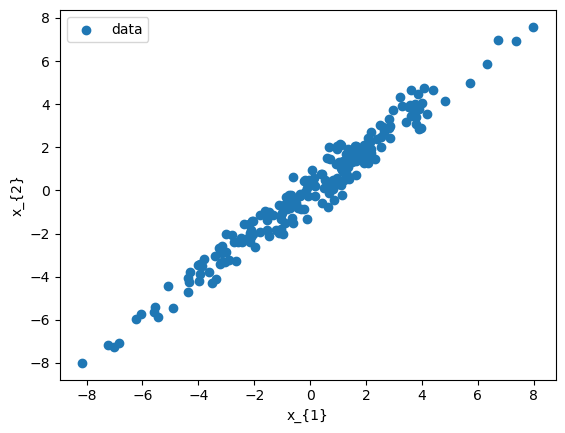

In [14]:
row_vec=torch.t(eigenvectors).numpy()
plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(),label="data")
# plt.quiver([0],[0],row_vec[:,0],row_vec[:,1],label="Eigen vectors")
plt.xlabel("x_{1}")
plt.ylabel("x_{2}")
plt.legend()
plt.show()


We find the projection  the eigenvectors:
$Z= \mathbf{X} \mathbf{Q} $

In [18]:
# new_Q = torch.zeros(2,2)
# max_eigenvalue = torch.argmax(eigenvalues[:,0])
# new_Q[:,0] = eigenvectors[:,max_eigenvalue] 

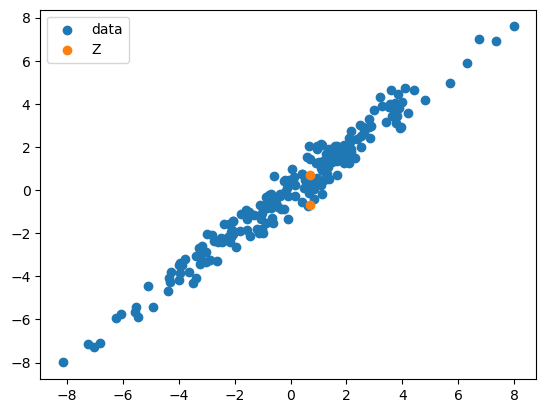

tensor([[ 1.6088e+01, -1.1158e-06],
        [-1.1158e-06,  1.4734e-01]])

In [17]:
Z=torch.mm(X,eigenvectors.float())
plot_data(X,eigenvectors.float(),label_X="data",label_Xhat="Z",lable_vec="q")
torch.mm(torch.transpose(Z,0,1),Z)/Z.size()[0]


We can also find the $\mathbf{\hat{X}}$, as we are using all the vectors, we have a perfect reconstruction. 
$\mathbf{\hat{X}}=\mathbf{Q} \mathbf{Z} $

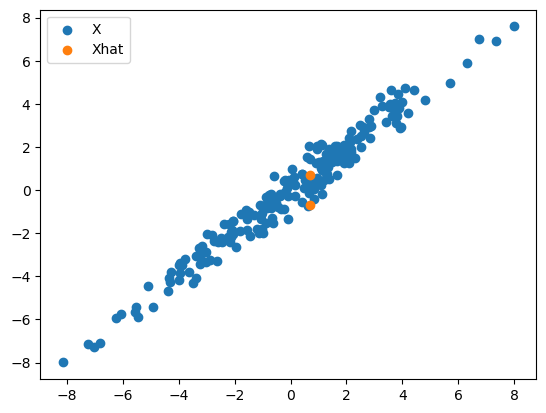

In [19]:
Xhat=torch.mm(Z,torch.transpose(eigenvectors.float(),0,1))
plot_data(Xhat,eigenvectors.float(),label_X="X",label_Xhat="Xhat",lable_vec="parameter vector")

We can also find the max eigenvalue  

In [23]:
# max_eigenvalue=torch.argmax(eigenvalues[:,0])
max_eigenvalue=torch.argmax(eigenvalues.float())
max_eigenvalue

tensor(0)

we find the corresponding max eigenvector

In [24]:
max_eigenvector=eigenvectors[:,max_eigenvalue]

To keep the tensors the same shape we simply copy the eigenvector to a new tensor. This behaves like setting the other eigenvector to zero.

In [25]:
new_Q=torch.zeros(2,2)
new_Q[:,0]=max_eigenvector

We find Xhat, this time as it’s an approximation all the points fall on the line that is a scaler multiple of are eigenvector.   

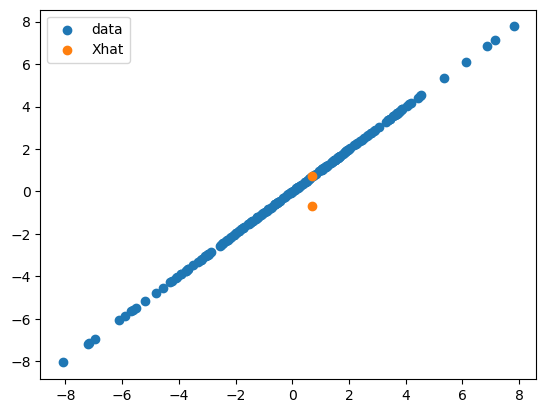

In [26]:
Z=torch.mm(X,new_Q)
Xhat=torch.mm(Z,torch.transpose(new_Q,0,1))
plot_data(Xhat,eigenvectors.float(),label_X="data",label_Xhat="Xhat",lable_vec="parameter vector")

<h2 id="#A2D<">Autoencoders 2D </h2> 

We do the same for an autoencoder, but instead of only selecting one eigenvector we set the code length to be one.

In [27]:
model=AutoEncoder(2,1)

Just like a neural network we train the encoder using gradient descent.   

In [28]:
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
cost_list_training=train_model(model,X,optimizer,n_epochs=4)

We can make a prediction for <code>Xhat</code>  and plot it.  

In [29]:
Xhat=model(X)

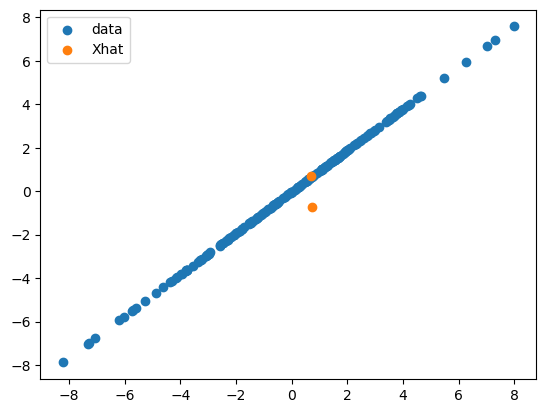

In [30]:
plot_data(model(X).detach(),eigenvectors.float(),label_X="data",label_Xhat="Xhat",lable_vec="parameter vector")

We see that the output is similar to  PCA. The data spans a line.

<h2 id="#PCA3D<"> PCA 3D</h2>

 Let’s do the same for three dimensional points  

$\mathbf{\hat{X}}=\mathbf{X} \mathbf{Q} \mathbf{\Lambda}^{-1/2} $

Let’s do the same for three dimensional points. We will generate  some data from a plane and add noise. We will convert it to a PyTorch tensor and subtract the mean. 

In [32]:
TureData,CorruptedData=GenerateData(ProjectionMatrix=[[1,-1,0],[2,1,0],[0,0,0]],Noise_std=0.1,Nsamples=1000)
print(TureData)
X=torch.from_numpy(CorruptedData).float()
X=X-X.mean(dim=0)

[[-0.28566697  0.87802753  0.        ]
 [-0.18965253 -0.92999281  0.        ]
 [ 0.11817939  2.24870113  0.        ]
 ...
 [ 1.77843457  1.17216631  0.        ]
 [ 0.62513885 -0.33537538  0.        ]
 [ 0.54374733  0.26285229  0.        ]]


We can plot out the original points in blue and overlay the points with added noise in red.

tensor([1., 0., 0.])
tensor([0., 1., 0.])
tensor([0., 0., 1.])


tensor([[-0.1088,  0.9215,  0.1022],
        [ 0.0349, -0.7397, -0.0934],
        [ 0.2137,  2.2371, -0.0060],
        ...,
        [ 1.6486,  1.2223,  0.0204],
        [ 0.6576, -0.1240, -0.0864],
        [ 0.5250,  0.1451, -0.0037]])

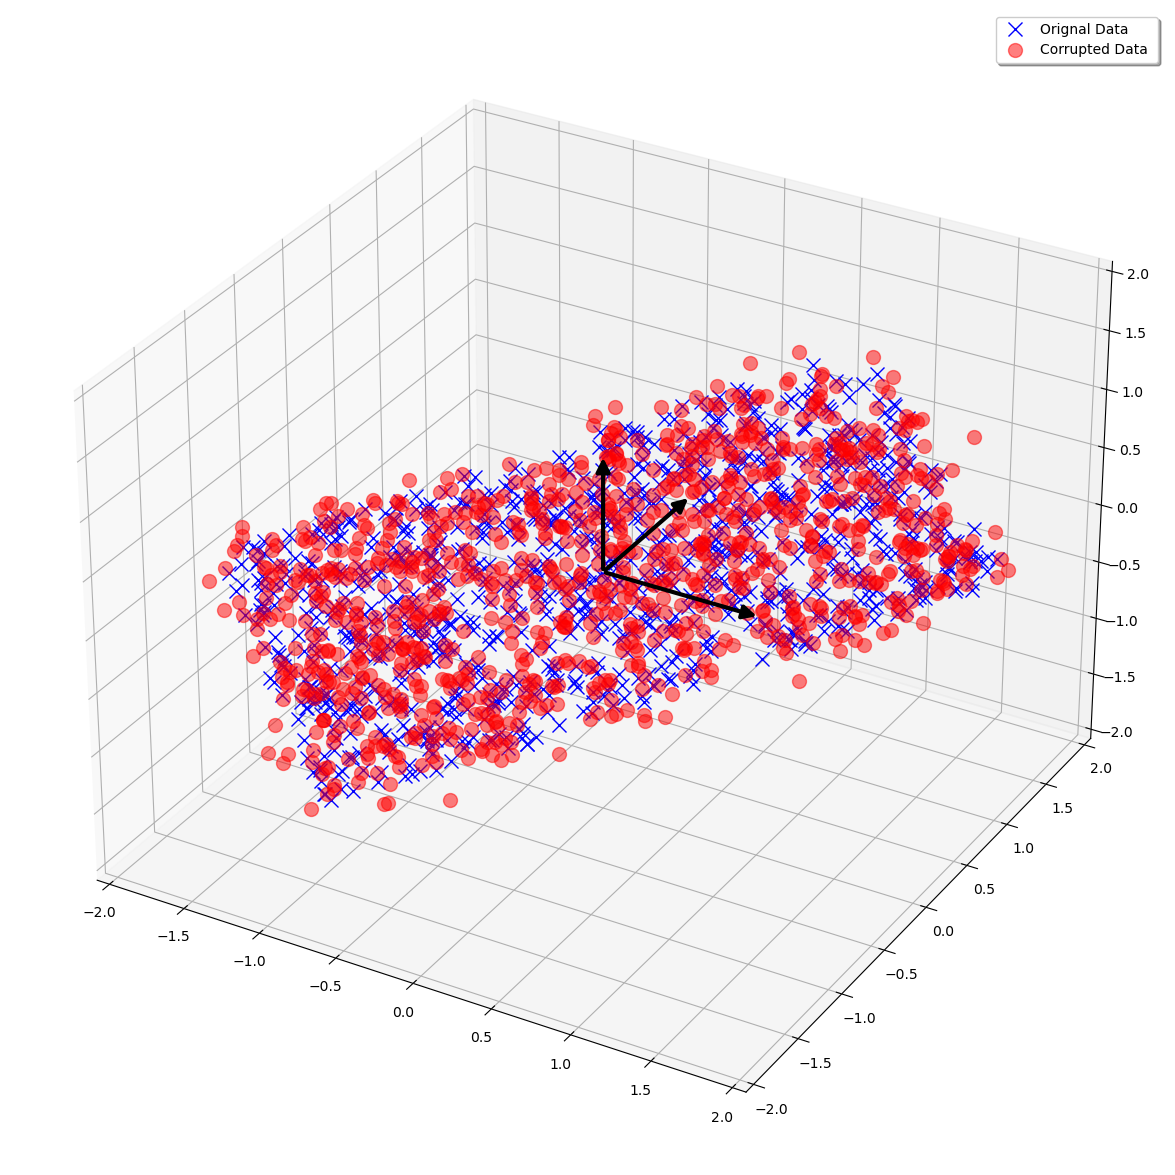

In [73]:
PlotData3D(TureData,CorruptedData,Name1="Orignal Data ",Name2="Corrupted Data ",BasisVectors=torch.eye(3))
X

We can determine covariance matrix and it  eigenvalues and eigenvectors

In [40]:
Cov=torch.mm(torch.t(X),X)/X.shape[0]
eigenvalues,eigenvectors=torch.linalg.eig(Cov)

We can verify  Orthogonal i.e parallel, more specifically orthonormal basis.

In [41]:
torch.mm(torch.transpose(eigenvectors,0,1),eigenvectors)

tensor([[ 1.0000e+00+0.j,  1.5915e-07+0.j,  8.7311e-11+0.j],
        [ 1.5915e-07+0.j,  1.0000e+00+0.j, -1.6735e-10+0.j],
        [ 7.2760e-11+0.j, -1.6735e-10+0.j,  1.0000e+00+0.j]])

We find the index of the first two largest eigenvectors:

In [45]:
indexs=set([0,1,2] )
# min_eigenvalues=torch.argmin(eigenvalues[:,0]).item()
min_eigenvalues=torch.argmin(eigenvalues.float()).item()
indexs.remove(min_eigenvalues)
indexs=list(indexs)
eigenvectors

tensor([[-3.2534e-01+0.j, -9.4560e-01+0.j, -1.3416e-04+0.j],
        [-9.4560e-01+0.j,  3.2534e-01+0.j, -1.7613e-04+0.j],
        [-2.1020e-04+0.j, -6.9554e-05+0.j,  1.0000e+00+0.j]])

To keep the tensors the same shape we simply copy the top eigenvector to a new tensor. This behaves like setting the other eigenvector to zero.

In [46]:
new_Q=torch.zeros(3,3)
for i,index in enumerate(indexs):
    new_Q[:,i]=eigenvectors[:,index]

We find the code and the prediction  $\mathbf{\hat{X}}$.

In [47]:
Z=torch.mm(X,new_Q)
Z
Xhat=torch.mm(Z,torch.transpose(new_Q,0,1))

We compare the output compared to the data points with noise. We see the  output points fall in the line.

In [49]:
# PlotData3D(Xhat.numpy(),CorruptedData,Name1="Xhat",Name2="Data with Noise",BasisVectors=new_Q)

<h2 id="A3D<"> Autoencoder in 3D</h2> 

We can perform a similar process with an Autoencoder but the vectors are not the same. We can verify this by showing that the basis are not orthogonal.

In [50]:
model=AutoEncoder(3,3)
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
cost_list_training=train_model(model,X,optimizer,n_epochs=4)
Xhat=model(X)
torch.mm(torch.transpose(model.state_dict()['encoder.weight'],0,1), model.state_dict()['encoder.weight'])


tensor([[ 0.9660,  0.2075, -0.0042],
        [ 0.2075,  1.4076, -0.6124],
        [-0.0042, -0.6124,  0.2985]])

We can use the autoencoder for dimensionality reduction as well, we can reduce the code to two. 

In [51]:
model=AutoEncoder(3,2)
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
cost_list_training=train_model(model,X,optimizer,n_epochs=4)
model.state_dict()

OrderedDict([('encoder.weight',
              tensor([[-0.3922, -0.9997,  0.4324],
                      [ 0.9905, -0.3545,  0.3538]])),
             ('encoder.bias', tensor([ 0.3430, -0.0090])),
             ('decoder.weight',
              tensor([[-0.3160,  0.8850],
                      [-0.8714, -0.3466],
                      [ 0.0062,  0.0046]])),
             ('decoder.bias', tensor([0.1152, 0.2992, 0.0021]))])

In [52]:
model.encoder(X)

tensor([[-0.4914, -0.4073],
        [ 1.0285,  0.2548],
        [-1.9798, -0.5926],
        ...,
        [-1.5168,  1.1978],
        [ 0.1716,  0.6557],
        [-0.0096,  0.4582]], grad_fn=<AddmmBackward0>)

We can see the output spans the same plane.   

tensor([-0.3160, -0.8714,  0.0062])
tensor([ 0.8850, -0.3466,  0.0046])


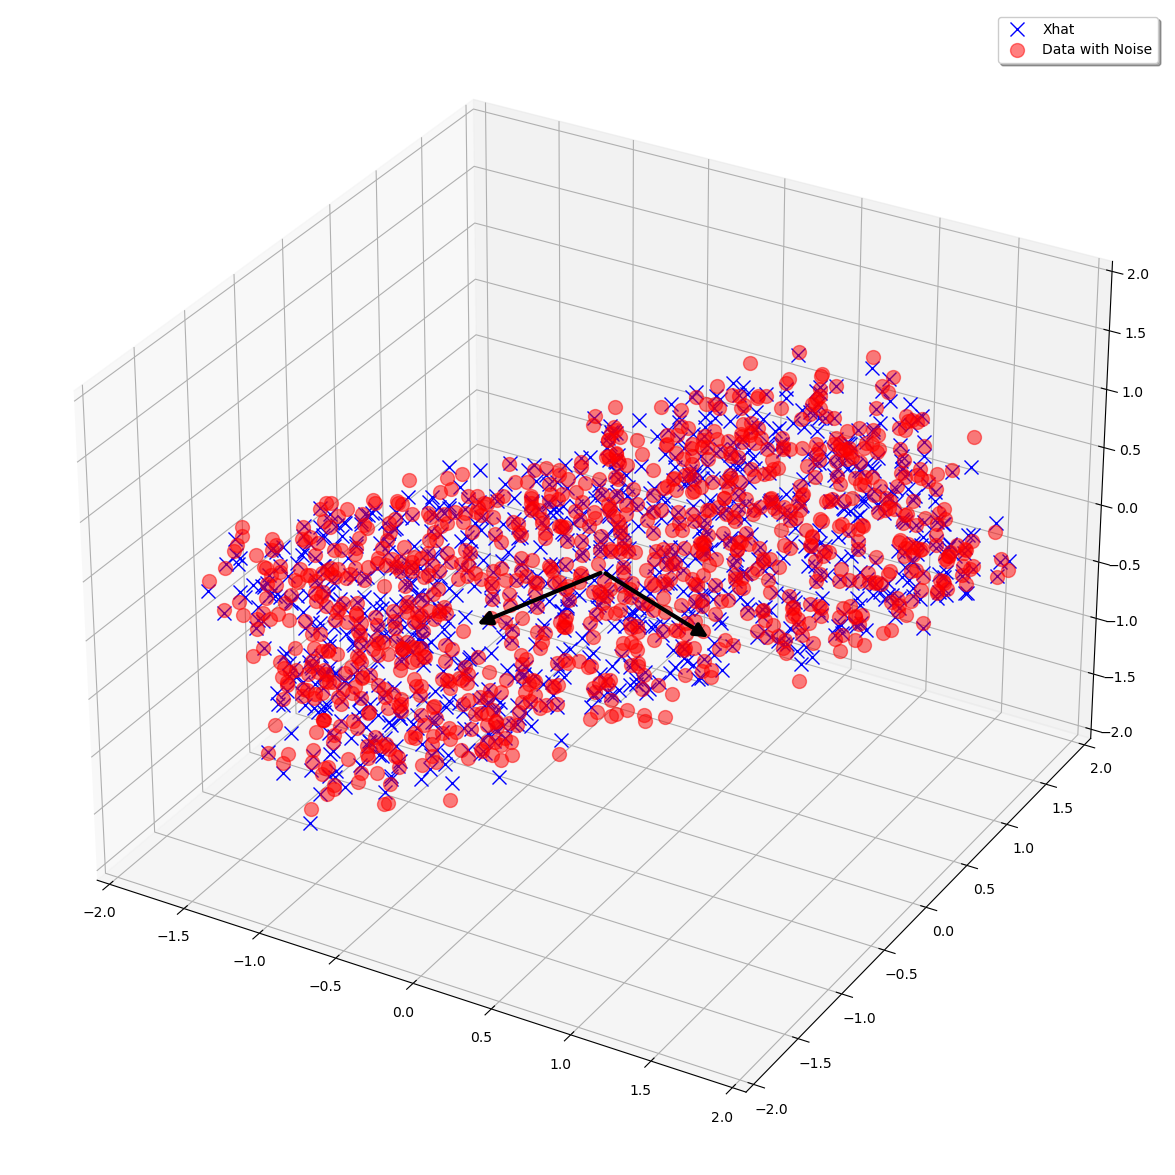

In [75]:
Xhat=model(X)
PlotData3D(Xhat.detach().numpy(),CorruptedData,Name1="Xhat",
           Name2="Data with Noise",BasisVectors=model.state_dict()['decoder.weight'].detach())

<!--Empty Space for separating topics-->

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.

<hr>

Copyright &copy; 2020 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.